In [1]:
import os
import numpy as np
from keras import optimizers
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Input, Embedding, LSTM, Dense, concatenate
from keras.models import Model, Sequential, load_model
from keras.layers.wrappers import TimeDistributed
from random import shuffle
import csv
import pickle
#from dictionaries import d_words_g
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import random
from pathlib import Path
import pdb
WITH_END = True

Using TensorFlow backend.


In [2]:
def participants_gen_with_end(synt_out=True, wave_out=False, repeat_words=True, train_gen=True):
    """Generates batches of sentences corresponding to the grammatical condition
    of Ding et all (2016). The Input words correspond to Word2Vec representations
    from Frank & Yang (2018).

    Input structure:    start, adj,  noun, verb, noun.
    Criteria structure: adj,   noun, verb, noun, end.

    Args:
        p_id: participant id. Determines the Word2Vec dictionary used for the input words.
        synt_out: if True adds a secondary syntactic vector to the criteria.
            This vector codes for the current syntactic structure: NP, VP, S.
        wave_out: if True adds a secondary vector of size 3 with sine waves at
            1hz, 2hz and 3hz to the criteria.
        repeat_words: if True words in the input sentences are repeated 4 times,
            otherwise filled with 'NONE' 3 times.

    Returns:
        A tuple of inputs and labels for training.
    """

    # Load dictionaries
    new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
    new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]

    # Load words as lists
    with open(str(Path(os.getcwd()).parent) + '\\Data\\Ding_grammatical.csv', 'r') as f:
        sentence_list = [row for row in csv.reader(f)]

    while True:
        # Shuffle sentence list every time
        shuffle(sentence_list)

        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        synt_codes_batch = []

        for ind,sent in enumerate(sentence_list):
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3], sent[3]]
                

            else:                
                input_words = ['NONE', 'NONE', 'NONE', 'NONE', sent[0],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[1],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[2],
                               'NONE', 'NONE', 'NONE', 'NONE', sent[3]]
            
            if WITH_END:
                output_words = [sent[0], sent[0], sent[0], sent[0], sent[1],
                                sent[1], sent[1], sent[1], sent[1], sent[2],
                                sent[2], sent[2], sent[2], sent[2], sent[3],
                                sent[3], sent[3], sent[3], sent[3], 'END']
            else:
                output_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                                sent[1], sent[1], sent[1], sent[1], sent[1],
                                sent[2], sent[2], sent[2], sent[2], sent[2],
                                sent[3], sent[3], sent[3], sent[3], sent[3]]

            
            
            # Generate one-hot representation of words for output (the model takes as input the indices directly)
            input_vectors = [new_dict.item().get(word) for word in input_words]
            output_vectors = [np.eye(len(new_dict.item().keys()))[[*new_dict.item().keys()].index(word)] for word in output_words]

            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)

        # split into train and test data generator
        if train_gen == True:
            yield np.array(input_batch[0:]),np.array(output_batch[0:])
        else:
            yield np.array(input_batch[50:]),np.array(output_batch[50:])

In [3]:
# let us now try to predict the np - vp 
PID = 11
new_dict = np.load(str(Path(os.getcwd()).parent) + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
new_dict.item()['NONE'] = np.eye(new_dict.item()['cute'].shape[0])[0]
new_dict.item()['END'] = np.eye(new_dict.item()['cute'].shape[0])[1]

VOCAB = len(new_dict.item().keys())
train_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=True,repeat_words=False)
test_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=False,repeat_words=False)
model = Sequential()
model.add(LSTM(100,input_shape=(20,300),return_sequences=True,name='lstm'))
model.add(Dense(VOCAB, name='word_pred_1'))
nadam = optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                         schedule_decay=0.004)
model.compile(loss='mean_squared_error', optimizer=nadam)
print(model.summary())
model.fit_generator(generator=train_data_gen, steps_per_epoch=100, epochs=10,
                                         verbose=1)
if WITH_END:
    model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\scratch\\not_repeated_with_end_new.h5')
else:
    model.save(str(Path(os.getcwd()).parent) + '\\Data\\models\\scratch\\not_repeated_without_end_new.h5')
# train LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 100)           160400    
_________________________________________________________________
word_pred_1 (Dense)          (None, 20, 329)           33229     
Total params: 193,629
Trainable params: 193,629
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
100/100 [==============================] - 67s 674ms/step - loss: 0.0021
Epoch 2/10
100/100 [==============================] - 63s 631ms/step - loss: 0.0016
Epoch 3/10
100/100 [==============================] - 62s 625ms/step - loss: 0.0016
Epoch 4/10
100/100 [==============================] - 90s 904ms/step - loss: 0.0016
Epoch 5/10
100/100 [==============================] - 82s 816ms/step - loss: 0.0016
Epoch 6/10
100/100 [==============================] - 78s 784ms/step - loss: 0.0015
E

In [4]:
# power spectra function
def power_spectra(w2vec_array, sampling_rate=16):
    """Computes power spectra using the Discrete Fourier Transform.

    Args:
        w2vec_array: arrays of shape (n_sentences*time_steps, n_units)
            representing hidden layer activations in response to each word of the
            concatenated sequence of sentences.
        sample_rate: number of measures (outputs of the model) per second.

    Returns:
        Mean power spectra and frequency axis.
    """

    # Separate each unit and concatenate across words to form 1 vector per unit
    unit_vectors = np.transpose(w2vec_array)

    # Frequency domain
    # num_samples is just the number of data points for each unit
    num_samples = unit_vectors.shape[1]
    freq = np.fft.rfftfreq(num_samples, d=1./sampling_rate)
    print ('freq ' ,freq.shape)
    # Calculate the FFT and power spectra for each unit
    units_ps = []
    for vector in unit_vectors:
        ft_unit = np.fft.rfft(vector)  # fft
        ps_uni = np.abs(ft_unit) ** 2  # power spectrum
        units_ps.append(ps_uni)

    # Average power spectra over units
    units_ps = np.array(units_ps)
    mean_ps = np.mean(units_ps, axis=0)
    print ('mean_ps',mean_ps.shape)
    return freq, mean_ps, units_ps

In [5]:
def plot_results(plot_path, freq, power, act,sampling_rate=16,n_samples=60,title='Input stimuli',smoothed=True):
    """Plot all the results of one condition"""
    plt.rcParams['pdf.fonttype'] = 42 # for the eps files
    plt.rcParams['ps.fonttype'] = 42

    # Time domain parameters
    sampling_interval = 1.0/sampling_rate  # sampling interval
    t = np.arange(0, n_samples, sampling_interval)  # time vector
    # Build plot
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.suptitle(title)
    ax[0].plot(t, act, linewidth=1.0)
    # Axis labels
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    until_4 = np.where(freq==4)[0][0]
    print('Power difference ')
    #if smoothed == True:
    #    power = np.convolve(power, np.ones((50,))/50, mode='valid')
    ax[1].plot(freq[1:until_4+50], (power[1:until_4+50]), 'r', linewidth=1.0)
    ax[1].set_xlabel('Freq (Hz)')
    #ax[1].set_ylim([-1000, 9000])
    ax[1].set_ylabel('Power (db)')
    # Adjusts subplot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Save
    fig.savefig(plot_path+'.pdf')


In [6]:
def windowed_zscores(vals,window=10):
    scores = np.zeros(vals.shape)
    seq_length = vals.shape[0]
    for i in range(seq_length):
        # before window length is reached
        if i < window:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[0:i]]).mean()
        # less than window length remaining
        elif (i + window) > seq_length:
            scores[i] = vals[i] - np.concatenate([vals[i-window:i],vals[i+1:]]).mean()
        # after window length is reached
        else:
            scores[i] = vals[i] - np.concatenate([vals[i+1:i+1+window],vals[i-window:i]]).mean()
    return scores

freq  (601,)
mean_ps (601,)
Power difference 


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

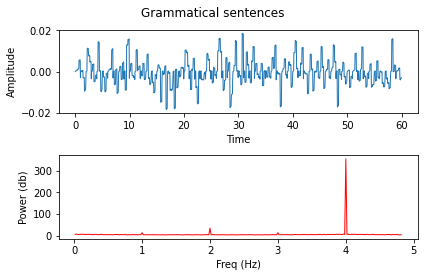

In [13]:
n_samples = 60
PID = 0
train_data_gen = participants_gen_with_end(synt_out=False,wave_out=False,train_gen=True,repeat_words=False)
train_data = next(train_data_gen)[0]

lstm_model = Model(inputs=model.input,outputs=model.get_layer('lstm').output)
lstm_outputs = lstm_model.predict_on_batch(train_data)
activations = np.reshape(lstm_outputs, (n_samples * 20, 100)) # activations shape becomes 1200 * 100 , 1200 timesteps, 100 units
embedded_inputs = np.reshape(train_data,(n_samples * 20, train_data.shape[2]))
freq,mean_ps,unit_ps = power_spectra(embedded_inputs,sampling_rate=20)
#mean_ps = windowed_zscores(vals=mean_ps,window=50)
if WITH_END:
    plot_results(plot_path=None,#str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed\\scratch\\grammatical', 
                 freq=freq,power=mean_ps, 
                 act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Grammatical sentences')
else:
    plot_results(str(Path(os.getcwd()).parent) + '\\Data\\plots-smoothed-without-end\\scratch\\input_stim', freq,power=mean_ps, 
                 act=np.mean(activations,axis=1),sampling_rate=20,n_samples=n_samples,title='Grammatical sentences')


In [11]:
temp = [i for i in range(60)]
print(len(temp))

60


In [2]:
def create_sentences(SenType = 'sen'):
    # possible sentypes: 
    # sen:          regular sentence
    # wordlist:     wordlists
    # nongrammar:   grammatically correct, nonsensical
    # nounphrase:   noun phrases
    # verbphrase:   verb phrases
    # random:       adjective noun verb noun random
    
    # Load dictionaries
    base = str(Path(os.getcwd()).parent)
    new_dict = np.load(base + '\\Data\\dic_word2vec_ding_new.npy',allow_pickle=True)
    new_dict.item()['NONE'] = np.zeros(new_dict.item()['cute'].shape[0])
    new_dict.item()['ENDW'] = np.zeros(new_dict.item()['cute'].shape[0])
    new_dict.item()['ENDS'] = np.zeros(new_dict.item()['cute'].shape[0])

    N = 60
    adjectives = list(np.genfromtxt(base + '\\Data\\Ding_adjective.csv',dtype=str))
    nouns = list(np.genfromtxt(base + '\\Data\\Ding_Noun.csv',dtype=str))
    verbs = list(np.genfromtxt(base + '\\Data\\Ding_verb.csv',dtype=str))
        
    if SenType == 'sen':
        # Load words as lists
        with open(base + '\\Data\\Ding_grammatical.csv', 'r') as f:
            sentence_list = [row for row in csv.reader(f)]
            
    elif SenType == 'wordlist':
        all_words = new_dict.item().keys()
        sentence_list = [random.sample(all_words,4) for i in range(N)]
        
    elif SenType == 'nongrammar':   
        sentence_list = list()
        for i in range(N):
            w1,w2,w3,w4 = '','','',''
            while w1 not in new_dict.item().keys():
                w1 = random.sample(adjectives,1)[0]
            while w2 not in new_dict.item().keys():
                w2 = random.sample(nouns,1)[0]
            while w3 not in new_dict.item().keys():
                w3 = random.sample(verbs,1)[0]
            while w4 not in new_dict.item().keys():
                w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'nounphrase':        
        sentence_list = list()
        for i in range(N):
            w1,w2,w3,w4 = '','','',''
            while w1 not in new_dict.item().keys():
                w1 = random.sample(adjectives,1)[0]
            while w2 not in new_dict.item().keys():
                w2 = random.sample(nouns,1)[0]
            while w3 not in new_dict.item().keys():
                w3 = random.sample(adjectives,1)[0]
            while w4 not in new_dict.item().keys():
                w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'verbphrase':
        sentence_list = list()
        for i in range(N):
            w1,w2,w3,w4 = '','','',''
            while w1 not in new_dict.item().keys():
                w1 = random.sample(verbs,1)[0]
            while w2 not in new_dict.item().keys():
                w2 = random.sample(nouns,1)[0]
            while w3 not in new_dict.item().keys():
                w3 = random.sample(verbs,1)[0]
            while w4 not in new_dict.item().keys():
                w4 = random.sample(nouns,1)[0]
            sentence_list.append([w1,w2,w3,w4])
            
    elif SenType == 'random':
        sentence_list = list()
        for i in range(N):
            w1,w2,w3,w4 = '','','',''
            while w1 not in new_dict.item().keys():
                w1 = random.sample(verbs,1)[0]
            while w2 not in new_dict.item().keys():
                w2 = random.sample(nouns,1)[0]
            while w3 not in new_dict.item().keys():
                w3 = random.sample(nouns,1)[0]
            while w4 not in new_dict.item().keys():
                w4 = random.sample(adjectives,1)[0]
            sentence_list.append([w1,w2,w3,w4]
            )    
    return sentence_list, new_dict


In [3]:
def participants_gen_with_end_SO(repeat_words=True, train_gen=True, withend = True, SenType = 'sen'):
    """Generates batches of sentences corresponding to the grammatical condition
    of Ding et all (2016). The Input words correspond to Word2Vec representations
    from Frank & Yang (2018).
   
    Args:
        train_gen: if it is for training (True) or testing (False)
        withend: output has only word endings or also sentence endings.
        repeat_words: if True words in the input sentences are repeated 4 times,
            otherwise filled with 'NONE' 3 times.
        SenType: 
            # sen:          regular sentence
            # wordlist:     wordlists
            # nongrammar:   adjective noun verb noun > grammatically correct, random words
            # nounphrase:   noun phrases
            # verbphrase:   verb phrases
            # random:       verb noun noun adjective
        
        
    Returns:
        A tuple of inputs and labels for training.
    """
    #pdb.set_trace()
    # load the sentences
    sentence_list, new_dict = create_sentences(SenType)  
        
    if train_gen == True: # keep selection of sentences apart for testing/training
        sentence_list = sentence_list[0:-13] # 60 - 13 = 47 sentences
        Ntrl = 20
    else:
        sentence_list = sentence_list[-13:]
        Ntrl = 10
    Nsen = len(sentence_list)   # 47 for training
    while True:      
        # Lists to store inputs and labels
        input_batch = []
        output_batch = []
        for ind,sent in enumerate(sentence_list):
            # Repeat words or fill with 'NONE'
            if repeat_words:
                # 50 ms sample time, 20 samples/second
                input_words = [sent[0], sent[0], sent[0], sent[0], sent[0],
                               sent[1], sent[1], sent[1], sent[1], sent[1],
                               sent[2], sent[2], sent[2], sent[2], sent[2],
                               sent[3], sent[3], sent[3], sent[3], sent[3]]                

            else:                
                input_words = ['NONE', sent[0], sent[0], sent[0], sent[0],
                               'NONE', sent[1], sent[1], sent[1], sent[1],
                               'NONE', sent[2], sent[2], sent[2], sent[2],
                               'NONE', sent[3], sent[3], sent[3], sent[3]]
                
            if withend:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'ENDW',
                                   sent[1], sent[1], sent[1], sent[1], 'ENDW',
                                   sent[2], sent[2], sent[2], sent[2], 'ENDW',
                                   sent[3], sent[3], sent[3], sent[3], 'ENDS']
            else:
                output_words = [sent[0], sent[0], sent[0], sent[0], 'ENDW',
                                   sent[1], sent[1], sent[1], sent[1], 'ENDW',
                                   sent[2], sent[2], sent[2], sent[2], 'ENDW',
                                   sent[3], sent[3], sent[3], sent[3], 'ENDW']
                
                                    
            # Generate one-hot representation of words for output (the model takes as input the indices directly)
            input_vectors = [new_dict.item().get(word) for word in input_words]
            output_vectors = [np.eye(len(new_dict.item().keys()))[[*new_dict.item().keys()].index(word)] for word in output_words]
            # Append to batch lists
            input_batch.append(input_vectors)
            output_batch.append(output_vectors)
        #pdb.set_trace()
        # in the Ding et al., 2016 they had 12 repetitions of sentences per trial for a total of 22 trials (but we are going to up this)                       
        input_batchT = np.array(input_batch) # shape = 47 x 20 x 300       
        output_batchT = np.array(output_batch).astype(bool)  # shape = 47 x 20 x N (Ndim of one hot encoding)
        
        r = 13 #(then start at random lags)
        usedSenCom = np.zeros([Ntrl,r])+Nsen+1  # Fill a 20 x 13 matrix with vals = 48
        input_batchFS = np.zeros([Ntrl,r*input_batchT.shape[1],input_batchT.shape[2]]) # 20 x (260) x 300
        output_batchFS = np.zeros([Ntrl,r*output_batchT.shape[1],output_batchT.shape[2]]) # 20 x (260) x N
        for trl in range(Ntrl):  # (0:20)              
            # check if doesn't exist
            check = False            
            while check==False:
                rp = np.random.permutation(Nsen) # vector of shape 47 x 1 containing randomly arranged elements in (0-47)
                n = 0
                for it in range(r): # (0:13)
                    if rp[it] in usedSenCom[:,it]: # if [random_permutation(0:47)][it] in usedSenCom[:,it]                            
                        n = n + 1
                if n <= r:
                    check = True
            usedSenCom[trl,:] = rp[0:r] # replace trl row with the random permutations
            for it in range(r): # (0:13)             
                input_batchFS[trl,it*20:it*20+20,:] = input_batchT[rp[it],:,:]   
                output_batchFS[trl,it*20:it*20+20,:] = output_batchT[rp[it],:,:]   
        # create all the lags:
        l = 19
        input_batchFS2 = np.zeros([Ntrl*l,240,input_batchT.shape[2]])
        output_batchFS2 = np.zeros([Ntrl*l,240,output_batchT.shape[2]]).astype(bool)
        #output_batch = np.zeros([Ntrl*l, 3])
        for lcnt in range(l):
            input_batchFS2[lcnt*Ntrl:Ntrl*lcnt+Ntrl,:,:] = input_batchFS[:,lcnt:-(l-lcnt)-1,:]
            output_batchFS2[lcnt*Ntrl:Ntrl*lcnt+Ntrl,:,:] = output_batchFS[:,lcnt:-(l-lcnt)-1,:]
                
        # split into train and test data generator
        rp = np.random.permutation(output_batchFS2.shape[0])
        yield input_batchFS2[rp,:,:],output_batchFS2[rp,:]


In [4]:
temp = participants_gen_with_end_SO()

In [5]:
temp2 = next(temp)

In [8]:
temp2[1].shape

(380, 240, 330)